In [42]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [43]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])
    
    X = data.get('X')
    
    if transpose:
        X = np.array([im.reshape((20, 20)).T for im in X])
        X = np.array([im.reshape(400) for im in X])
    
    return X,y

In [44]:
X, y = load_data('ex3data1.mat')
print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [45]:
def plot_an_image(image):
#     image : (400,)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
#绘图函数    

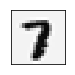

this should be 7


In [46]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))

In [47]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


# 准备数据

In [48]:
# add intercept=1 for x0
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
X.shape

(5000, 401)

In [49]:
y_matrix = []

for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))
    
y_matrix = [y_matrix[-1]] + y_matrix[:-1]#最后一列k=10，都是0，把最后一列放到第一列
y = np.array(y_matrix)

y.shape
# 扩展 5000*1 到 5000*10
#     比如 y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """

(10, 5000)

In [50]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# train 1 model （训练一维模型）

In [51]:
def cost(theta, X, y):
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

In [52]:
def regularized_cost(theta, X, y, l=1):
    theta_j1_to_n = theta[1:]
    regularized_term = (1 / (2 * len(X))) * np.power(theta_j1_to_n,2).sum()
    
    return cost(theta, X, y) + regularized_term

In [53]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n
    
    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])
    
    return gradient(theta, X, y) + regularized_term

In [54]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [55]:
def gradient(theta, X, y):
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)

In [56]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    #初始化 theta
    theta = np.zeros(X.shape[1])
    
    #训练
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    #得到训练参数
    final_theta = res.x
    return final_theta

In [57]:
def predict(x, theta):
    prob = sigmoid(X @ theta)
    return (prob >= 0.5).astype(int)

In [58]:
t0 = logistic_regression(X, y[0])

In [59]:
print(t0.shape)
y_pred = predict(X, t0)
print('Accuracy={}'.format(np.mean(y[0] == y_pred)))

(401,)
Accuracy=0.9974


# train k model （训练k维模型）

In [60]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(k_theta.shape)

(10, 401)


# 进行预测
* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [61]:
prob_matrix = sigmoid(X @ k_theta.T)

In [62]:
np.set_printoptions(suppress=True)
prob_matrix

array([[ 0.99577493,  0.        ,  0.00053479, ...,  0.0000647 ,
         0.00003913,  0.00172251],
       [ 0.99834718,  0.0000001 ,  0.00005606, ...,  0.00009687,
         0.0000029 ,  0.00008495],
       [ 0.99139784,  0.        ,  0.00056841, ...,  0.00000655,
         0.02648744,  0.00197472],
       ..., 
       [ 0.00000068,  0.04138765,  0.00321024, ...,  0.00012718,
         0.0029754 ,  0.70763552],
       [ 0.00001844,  0.00000013,  0.00000009, ...,  0.00164845,
         0.06829455,  0.86114402],
       [ 0.02880144,  0.        ,  0.0001297 , ...,  0.36611636,
         0.00498113,  0.14825941]])

In [63]:
y_pred = np.argmax(prob_matrix, axis=1)#返回沿轴axis最大值的索引，axis=1代表行

In [64]:
y_pred

array([0, 0, 0, ..., 9, 9, 7])

In [65]:
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0

In [66]:
print(classification_report(y_answer, y_pred))

             precision    recall  f1-score   support

          0       0.97      0.99      0.98       500
          1       0.95      0.99      0.97       500
          2       0.95      0.92      0.93       500
          3       0.95      0.91      0.93       500
          4       0.95      0.95      0.95       500
          5       0.92      0.92      0.92       500
          6       0.97      0.98      0.97       500
          7       0.95      0.95      0.95       500
          8       0.93      0.92      0.92       500
          9       0.92      0.92      0.92       500

avg / total       0.94      0.94      0.94      5000



# 神经网络模型图示
<img style="float: left;" src="../img/nn_model.png">

In [69]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [70]:
theta1, theta2 = load_weight('ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

 因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）


In [74]:
X, y = load_data('ex3data1.mat', transpose=False)
X = np.insert(X, 0 , values=np.ones(X.shape[0]), axis=1)#axis=1代表行
X.shape, y.shape

((5000, 401), (5000,))

# feed forward prediction（前馈预测）

In [76]:
a1 = X

In [77]:
z2 = a1 @ theta1.T #(5000, 401) @ (25,401).T = (5000, 25)
z2.shape

(5000, 25)

In [78]:
z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1)

In [79]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [80]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [81]:
a3 = sigmoid(z3)
a3

array([[ 0.00013825,  0.0020554 ,  0.00304012, ...,  0.00049102,
         0.00774326,  0.99622946],
       [ 0.00058776,  0.00285027,  0.00414688, ...,  0.00292311,
         0.00235617,  0.99619667],
       [ 0.00010868,  0.0038266 ,  0.03058551, ...,  0.07514539,
         0.0065704 ,  0.93586278],
       ..., 
       [ 0.06278247,  0.00450406,  0.03545109, ...,  0.0026367 ,
         0.68944816,  0.00002744],
       [ 0.00101909,  0.00073436,  0.00037856, ...,  0.01456166,
         0.97598976,  0.00023337],
       [ 0.00005908,  0.00054172,  0.0000259 , ...,  0.00700508,
         0.73281465,  0.09166961]])

In [82]:
a3.shape

(5000, 10)

In [85]:
y_pred = np.argmax(a3, axis=1) + 1 #返回沿轴axis最大值的索引，axis=1代表行
y_pred.shape

(5000,)

# 准确率
 
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [86]:
print(classification_report(y,y_pred))

             precision    recall  f1-score   support

          1       0.97      0.98      0.97       500
          2       0.98      0.97      0.97       500
          3       0.98      0.96      0.97       500
          4       0.97      0.97      0.97       500
          5       0.98      0.98      0.98       500
          6       0.97      0.99      0.98       500
          7       0.98      0.97      0.97       500
          8       0.98      0.98      0.98       500
          9       0.97      0.96      0.96       500
         10       0.98      0.99      0.99       500

avg / total       0.98      0.98      0.98      5000

